##**Problem statement:**

Fake news detection using SVM, and use kernel trick to compare the acuuracy.
We collected our dataset from kaggle, there were 'true.csv', and 'fake.csv' two datasets. 

we also used a little bit of NLP concept by using BOW, TF-IDF,word2Vec for vectorization. 
And then compared the result for 'linear' and 'rbf' Kernel. 

##**Group Members**
###**1.Kazi Hafiz Md Asad-(1921880042)**

###**2.Ahmed Akib Jawad Karim-(1911547042)**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Importing Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import plotly.express as px
import warnings

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
df_true = pd.read_csv("/content/drive/MyDrive/445_SVMFN/True.csv")
df_fake = pd.read_csv("/content/drive/MyDrive/445_SVMFN/Fake.csv")

#**Preparing the Data**

In [5]:
# Create 5th column
df_true['label'] = 1
df_fake['label'] = 0

# Concat dfs into one
df_all = pd.concat([df_true, df_fake]).reset_index(drop = True)
df_all.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [6]:
# Create 6th column
df_all['original'] = df_all['title'] + ' / ' + df_all['text']
df_all.head()

,title,text,subject,date,label,original
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,Trump wants Postal Service to charge 'much mor...


Lets take a note of the null values in the data.

In [7]:
df_all.isnull().sum()

title       0
text        0
subject     0
date        0
label       0
original    0
dtype: int64

# **Preprocessing and Cleaning** 

In [8]:
stop_words = stopwords.words('english')
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2 and token not in stop_words:
            result.append(token)
            
    return result

In [9]:
# Function to convert  
def listToString(s): 
    # initialize an empty string
    str1 = " "
    # return string  
    return (str1.join(s))

In [10]:
# Apply cleaning function to title and text
df_all['processed_title'] = df_all['title'].apply(preprocess)
df_all['processed_text'] = df_all['text'].apply(preprocess)

# then from list back to string
df_all['processed_title'] = df_all['processed_title'].apply(listToString)
df_all['processed_text'] = df_all['processed_text'].apply(listToString)
df_all.head()

,title,text,subject,date,label,original,processed_title,processed_text
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,"As U.S. budget fight looms, Republicans flip t...",budget fight looms republicans flip fiscal script,washington reuters head conservative republica...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,U.S. military to accept transgender recruits o...,military accept transgender recruits monday pe...,washington reuters transgender people allowed ...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,Senior U.S. Republican senator: 'Let Mr. Muell...,senior republican senator let mueller job,washington reuters special counsel investigati...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,FBI Russia probe helped by Australian diplomat...,fbi russia probe helped australian diplomat ti...,washington reuters trump campaign adviser geor...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,Trump wants Postal Service to charge 'much mor...,trump wants postal service charge amazon shipm...,seattle washington reuters president donald tr...


# Data Analysis

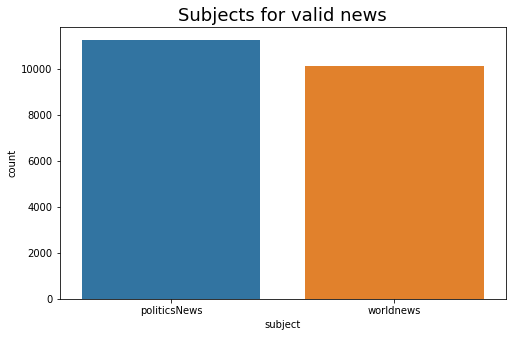

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x='subject', data=df_true, order=df_true.subject.value_counts().index[:,])
plt.title('Subjects for valid news', size=18);

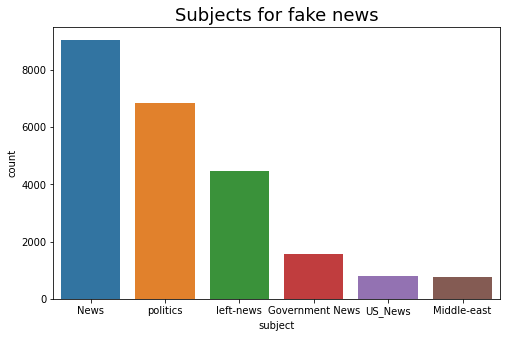

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x='subject', data=df_fake, order=df_fake.subject.value_counts().index[:,])
plt.title('Subjects for fake news', size=18);

In [ ]:
# plt.figure(figsize=(12,8))
# sns.countplot(x='subject', data=df_all, order=df_all.subject.value_counts().index[:,])
# plt.title('Subjects for all news', size=18);

## Average Number of Characters in Titles and Texts

In [ ]:
fig = px.histogram(x = [(len(x) - x.count(' ')) for x in df_all[df_all.label == 1].title])
fig.update_layout(title="Average Number of Characters in Valid News Titles")
fig.show()

In [ ]:
fig = px.histogram(x = [(len(x) - x.count(' ')) for x in df_all[df_all.label == 0].title])
fig.update_layout(title="Average Number of Characters in Fake News Titles")
fig.show()

Observation: On average, the maximum number of characters in titles of valid news range between  52−58  characters whereas the maximum number of characters in titles of fake news range between  70−79  characters. Would be a bit tricky to judge if the news are true or fake only by the number of characters in their titles. So lets continue until we find a better distinguishing factor

In [ ]:
fig = px.histogram(x = [(len(x) - x.count(' ')) for x in df_all[df_all.label == 1].text])
fig.update_layout(title="Average Number of Characters in Valid News Text")
fig.show()

In [ ]:
fig = px.histogram(x = [(len(x) - x.count(' ')) for x in df_all[df_all.label == 0].text])
fig.update_layout(title="Average Number of Characters in Fake News Text")
fig.show()

Observation: On average again, the maximum number of characters in texts of valid news range between  300−500  characters whereas the maximum number of characters in texts of fake news range between  1500−1900  characters. There is a clear difference here regarding the length of the words of the news articles. We also observe that some fake news articles have a little to none characters, which is an interesting pattern.

## Average Number of Words in Titles and Text

In [ ]:
fig = px.histogram(x = [len(x.split(" ")) for x in df_all[df_all.label == 1].title])
fig.update_layout(title="Average Number of Words in Valid News Titles")
fig.show()

In [ ]:
fig = px.histogram(x = [len(x.split(" ")) for x in df_all[df_all.label == 0].title])
fig.update_layout(title="Average Number of Words in Fake News Titles")
fig.show()

Observation: On average, the maximum number of words in titles of valid news range between 9-11 words whereas the maximum number of words in titles of fake news range between 13-16 words. Would be a bit tricky to judge if the news are true or fake only by the number of words in their titles.
. 

In [ ]:
fig = px.histogram(x = [len(x.split(" ")) for x in df_all[df_all.label == 1].text])
fig.update_layout(title="Average Number of Words in Valid News Text")
fig.show()

In [ ]:
fig = px.histogram(x = [len(x.split(" ")) for x in df_all[df_all.label == 0].text])
fig.update_layout(title="Average Number of Words in Fake News Text")
fig.show()

Observation: On average again, the maximum number of words in texts of valid news range between  60−100  and  400−420  words whereas the maximum number of words in texts of fake news range between  0−20  and  310−370  words. There is a clear difference here regarding the length of the news articles.



## Average Number of Modyfied Words in Titles and Text

In [ ]:
fig = px.histogram(x = [len(x.split(" ")) for x in df_all[df_all.label == 1].processed_title])
fig.update_layout(title="Average Number of Words in Valid News Titles after modifying them")
fig.show()

In [ ]:
fig = px.histogram(x = [len(x.split(" ")) for x in df_all[df_all.label == 0].processed_title])
fig.update_layout(title="Average Number of Words in Fake News Titles after modifying them")
fig.show()

In [ ]:
fig = px.histogram(x = [len(x.split(" ")) for x in df_all[df_all.label == 1].processed_text])
fig.update_layout(title="Average Number of Words in Valid News Text after modifying them")
fig.show()

In [ ]:
fig = px.histogram(x = [len(x.split(" ")) for x in df_all[df_all.label == 0].processed_text])
fig.update_layout(title="Average Number of Words in Fake News Text after modifying them")
fig.show()

## Common Bigrams in Titles and Text

In [11]:
#the most common continuous sequence of 2 items from the given title and text (valid and fake news).
# Get the valid news title words
true_title_words = [x.split(' ') for x in df_all[df_all.label == 1].processed_title]
# Flatten the list
true_title_words = [item for sublist in true_title_words for item in sublist]

# Get the bigrams
bigram_all = (pd.Series(ngrams(true_title_words, 2)).value_counts())[:10]
bigram_all=pd.DataFrame(bigram_all)

print("Top 10 most common bigrams in Valid News Titles: ")
bigram_all

Top 10 most common bigrams in Valid News Titles: 


,0
"(white, house)",790
"(north, korea)",720
"(trump, says)",364
"(islamic, state)",251
"(supreme, court)",235
"(puerto, rico)",178
"(south, korea)",160
"(says, trump)",159
"(travel, ban)",156
"(trump, administration)",148


In [12]:
#the fake news title words
fake_title_words = [x.split(' ') for x in df_all[df_all.label == 0].processed_title]
# Flatten the list
fake_title_words = [item for sublist in fake_title_words for item in sublist]

#the bigrams
bigram_all = (pd.Series(ngrams(fake_title_words, 2)).value_counts())[:10]
bigram_all=pd.DataFrame(bigram_all)

print("Top 10 most common bigrams in Fake News Titles: ")
bigram_all

Top 10 most common bigrams in Fake News Titles: 


,0
"(donald, trump)",805
"(video, watch)",509
"(president, trump)",504
"(video, trump)",460
"(hillary, clinton)",417
"(white, house)",348
"(fox, news)",314
"(trump, video)",311
"(video, breaking)",270
"(anti, trump)",261


In [13]:
#the valid news text words
true_text_words = [x.split(' ') for x in df_all[df_all.label == 1].processed_text]
# Flatten the list
true_text_words = [item for sublist in true_text_words for item in sublist]

#the bigrams
bigram_all = (pd.Series(ngrams(true_text_words, 2)).value_counts())[:10]
bigram_all=pd.DataFrame(bigram_all)

print("Top 10 most common bigrams in Valid News Text: ")
bigram_all

Top 10 most common bigrams in Valid News Text: 


,0
"(united, states)",12204
"(donald, trump)",10168
"(white, house)",8419
"(washington, reuters)",6679
"(president, donald)",5930
"(north, korea)",5659
"(new, york)",4740
"(prime, minister)",4163
"(said, statement)",3934
"(trump, said)",3586


In [14]:
# Get the fake news text words
fake_text_words = [x.split(' ') for x in df_all[df_all.label == 0].processed_text]
# Flatten the list
fake_text_words = [item for sublist in fake_text_words for item in sublist]

#the bigrams
bigram_all = (pd.Series(ngrams(fake_text_words, 2)).value_counts())[:10]
bigram_all=pd.DataFrame(bigram_all)

print("Top 10 most common bigrams in Fake News Text: ")
bigram_all

Top 10 most common bigrams in Fake News Text: 


,0
"(donald, trump)",16395
"(featured, image)",8063
"(hillary, clinton)",7307
"(white, house)",6745
"(united, states)",6663
"(twitter, com)",6567
"(pic, twitter)",6232
"(new, york)",4359
"(president, obama)",4095
"(president, trump)",4049


# Model Training and Classification

## Createing, Training and Test Datasets

In [15]:
# creating new csv files
# getting a percentage (fraction) of all the news using frac argument with random choices, use frac=1 for whole dataset
sampled = df_all.sample(frac=1, random_state=7,replace=True)

# split train and test dataframes
position = int(sampled.shape[0] * 0.8)
train = sampled.iloc[:position]
test = sampled.iloc[position:]

# removing unwanted columns
test = test.drop(columns=['original', 'text', 'title'])
train = train.drop(columns=['original', 'text', 'title'])
# renaming columns
test = test.rename(columns={'processed_title': 'title', 'processed_text': 'text'})
train = train.rename(columns={'processed_title': 'title', 'processed_text': 'text'})

# saving...
test.to_csv(r"test.csv")
train.to_csv(r"train.csv")

!cp test.csv "/content/drive/MyDrive/445_SVMFN"
!cp train.csv "/content/drive/MyDrive/445_SVMFN"

We have created the train and test datasets. Let's see now their analogies and their sizes...

In [ ]:
# printing the sizes of the dataframes
print("Number of news in TEST dataset is -> ", test.shape[0])
print("Number of news in TRAIN dataset is -> ", train.shape[0], "\n")

print("The number of the FAKE news in the TRAIN dataset is -> " + str(train[train.label == 0].shape[0]))
print("The number of the TRUE news in the TRAIN dataset is -> " + str(train[train.label == 1].shape[0]))
print("Analogy of real-fake news is -> " + str(round((train[train.label == 0].shape[0]/train.shape[0])*100,2)) + "% - " + str(round((train[train.label == 1].shape[0]/train.shape[0])*100,2)) +"%")
print("")
print("The number of the FAKE news in the TEST dataset is -> " + str(test[test.label == 0].shape[0]))
print("The number of the TRUE news in the TEST dataset is -> " + str(test[test.label == 1].shape[0]))
print("Analogy of real-fake news is -> " + str(round((test[test.label == 0].shape[0]/test.shape[0])*100,2)) + "% - " + str(round((test[test.label == 1].shape[0]/test.shape[0])*100,2)) +"%")


Number of news in TEST dataset is ->  8980
Number of news in TRAIN dataset is ->  35918 

The number of the FAKE news in the TRAIN dataset is -> 18797
The number of the TRUE news in the TRAIN dataset is -> 17121
Analogy of real-fake news is -> 52.33% - 47.67%

The number of the FAKE news in the TEST dataset is -> 4624
The number of the TRUE news in the TEST dataset is -> 4356
Analogy of real-fake news is -> 51.49% - 48.51%


## News Classification

In [16]:
def document_vector(doc, w2v):
  # Create document vectors by averaging word vectors
  doc = doc.split(' ')
  doc = [word for word in doc if word in w2v.wv.vocab]

  return np.mean(w2v[doc], axis=0)

In [17]:
def ignore_warnings():
  # ignore the deprecassion warning
  warnings.filterwarnings("ignore")

In [18]:
def enable_warnings():
  warnings.simplefilter('always')

### Compute Vectorizers(count - tfidf - word2vec)

In [19]:
ignore_warnings()

# COUNT VECTORIZER
CountVec = CountVectorizer(
                        ngram_range=(1,2), # (1, 1) means only unigrams, (1, 2) means unigrams and bigrams, and (2, 2) means only bigrams
                        lowercase=True
                        )
# Initializing some parameters one time to be used by BOW implementation models
vec_train = CountVec.fit(train.text)
X_vec_train = vec_train.transform(train.text)
X_vec_test = vec_train.transform(test.text)

# TF-IDF VECTORIZER
tf_idf_vec = TfidfVectorizer(
                      use_idf=True,
                      ngram_range=(1,2), # (1, 1) means only unigrams, (1, 2) means unigrams and bigrams, and (2, 2) means only bigrams
                      smooth_idf=True, # Prevents divide-by-zero errors
                      lowercase=True # Convert everything to lower case 
                      )
# Initializing some parameters one time to be used by TF-IDF implementation models
vec_train_tf = tf_idf_vec.fit(train.text)
X_vec_train_tf = vec_train_tf.transform(train.text)
X_vec_test_tf = vec_train_tf.transform(test.text)

# Word2Vec VECTORIZER

# creating a list of words from the titles
X = [x.split(' ') for x in train.text]

EMBEDDING_DIM = 100
# creating the w2v model
w2v = gensim.models.Word2Vec(sentences=X, size=EMBEDDING_DIM, window=5, min_count=1)
# creating temp dataframes
trainTemp = train
testTemp = test

# Initializing some parameters one time to be used by word2vec implementation models

# applying the function and creating a new column
trainTemp['doc_vector'] = trainTemp.text.apply(document_vector, args=(w2v,))
testTemp['doc_vector'] = testTemp.text.apply(document_vector, args=(w2v,))

X_train = list(trainTemp['doc_vector'])
X_test = list(testTemp['doc_vector'])

y_train = train.label
y_test = test.label

##**SVM**

In [ ]:
def SVMCountImplementation(train, test):
  # SVM classifier
  classifier = SVC(kernel = 'linear', random_state = 0)
  classifier.fit(X_vec_train, y_train)

  # Predicting the Test set results
  y_pred = classifier.predict(X_vec_test)

  accuracy_value = roc_auc_score(test.label, y_pred)

  print("Accuracy -> " + str(round(accuracy_value*100,2)) + "%")
  print("f1 score -> " + str(f1_score(test.label,y_pred)))

In [ ]:
def SVMTfidfImplementation(train, test):
  # SVM Classifier
  classifier = SVC(kernel = 'linear', random_state = 0)
  classifier.fit(X_vec_train_tf, y_train)

  # Predicting the Test set results
  y_pred = classifier.predict(X_vec_test_tf)

  accuracy_value = roc_auc_score(test.label, y_pred)

  print("Accuracy -> " + str(round(accuracy_value*100,2)) + "%")
  print("f1 score -> " + str(f1_score(test.label,y_pred)))

In [ ]:
def SVMWord2VecImplementation(train, test):
  # SVM classifier 
  classifier = SVC(kernel = 'linear', random_state = 0)
  classifier.fit(X_train, train.label)

  # Predicting the Test set results
  y_pred = classifier.predict(X_test)

  accuracy_value = roc_auc_score(test.label, y_pred)

  print("Accuracy -> " + str(round(accuracy_value*100,2)) + "%")
  print("f1 score -> " + str(f1_score(test.label,y_pred)))

In [ ]:
print("SVM with BOW, Tf-Idf and Word2Vec accordingly")
ignore_warnings()
SVMCountImplementation(train,test)
SVMTfidfImplementation(train,test)
SVMWord2VecImplementation(train,test)
enable_warnings()

SVM with BOW, Tf-Idf and Word2Vec accordingly
Accuracy -> 99.62%
f1 score -> 0.9961000229410415
Accuracy -> 99.31%
f1 score -> 0.9927975305819138
Accuracy -> 97.73%
f1 score -> 0.9765633931633703


##**SVM using Kernel Trick**

In [21]:
def SVMCountImplementation(train, test):
  # SVM classifier
  classifier = SVC(kernel = 'rbf', random_state = 0)
  classifier.fit(X_vec_train, y_train)

  # Predicting the Test set results
  y_pred = classifier.predict(X_vec_test)

  accuracy_value = roc_auc_score(test.label, y_pred)

  print("Accuracy -> " + str(round(accuracy_value*100,2)) + "%")
  print("f1 score -> " + str(f1_score(test.label,y_pred)))

In [22]:
def SVMTfidfImplementation(train, test):
  # SVM Classifier
  classifier = SVC(kernel = 'rbf', random_state = 0)
  classifier.fit(X_vec_train_tf, y_train)

  # Predicting the Test set results
  y_pred = classifier.predict(X_vec_test_tf)

  accuracy_value = roc_auc_score(test.label, y_pred)

  print("Accuracy -> " + str(round(accuracy_value*100,2)) + "%")
  print("f1 score -> " + str(f1_score(test.label,y_pred)))

In [23]:
def SVMWord2VecImplementation(train, test):
  # SVM classifier 
  classifier = SVC(kernel = 'rbf', random_state = 0)
  classifier.fit(X_train, train.label)

  # Predicting the Test set results
  y_pred = classifier.predict(X_test)

  accuracy_value = roc_auc_score(test.label, y_pred)

  print("Accuracy -> " + str(round(accuracy_value*100,2)) + "%")
  print("f1 score -> " + str(f1_score(test.label,y_pred)))

In [24]:
print("SVM with (rbf Kernel)BOW, Tf-Idf and Word2Vec accordingly")
ignore_warnings()
SVMCountImplementation(train,test)
SVMTfidfImplementation(train,test)
SVMWord2VecImplementation(train,test)
enable_warnings()

SVM with (rbf Kernel)BOW, Tf-Idf and Word2Vec accordingly
Accuracy -> 99.62%
f1 score -> 0.9961000229410415
Accuracy -> 99.31%
f1 score -> 0.9927975305819138
Accuracy -> 97.64%
f1 score -> 0.9756599245800479
